<a href="https://colab.research.google.com/github/david-siqi-liu/cs684-final-project/blob/master/cs684_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data

In [0]:
!rm -rf sample_data

In [0]:
from urllib.request import urlretrieve
import os
from zipfile import ZipFile

def download(url, file):
    if not os.path.isfile(file):
        urlretrieve(url, file)

#If the downloaded file is a zip file than you can use below function to unzip it.
def uncompress_features_labels(source, file, dest):
    if not os.path.isdir(file):
        with ZipFile(source) as zipf:
            zipf.extractall(dest)

'clipart.zip', 'infograph.zip', 'quickdraw.zip', 'real.zip', 'sketch.zip'

In [5]:
import time

start = time.process_time()

# Images
for file in ['clipart.zip', 'infograph.zip', 'quickdraw.zip', 'real.zip', 'sketch.zip']:
  download('http://csr.bu.edu/ftp/visda/2019/multi-source/' + file,
           file)
  print("Downloaded: {0}".format(file))
  uncompress_features_labels(file,
                             'data/' + file.split('.zip')[0],
                             'data/')
  print("Extracted: {0}".format(file))
  
print(time.process_time() - start)

Downloaded: clipart.zip
Extracted: clipart.zip
Downloaded: infograph.zip
Extracted: infograph.zip
Downloaded: quickdraw.zip
Extracted: quickdraw.zip
Downloaded: real.zip
Extracted: real.zip
Downloaded: sketch.zip
Extracted: sketch.zip
0.001237383000045611


In [0]:
!mkdir label

# Labels
for file in ['clipart', 'infograph', 'quickdraw', 'real', 'sketch']:
  download('http://csr.bu.edu/ftp/visda/2019/multi-source/txt/' + file + '_train.txt',
           'label/' + file + '_train.txt')
  download('http://csr.bu.edu/ftp/visda/2019/multi-source/txt/' + file + '_test.txt',
           'label/' + file + '_test.txt')

# Import Packages

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from PIL import Image, ImageColor
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Images and Labels

In [0]:
###### LIST LOADER #######

def default_loader(path):
    """Default loader
    """
    return Image.open(path).convert('RGB')

def collect_images(img_dir, labels):
  """Return a list of (image path, label)

  Parameters:
  img_dir (String) : the directory containing the images
  labels (List[String]) : a list of labels (merged multiple sources together)

  Returns:
  List[(String, String)]
  """
  images = []
  for line in labels:
    data = line.strip().split(' ')
    path = os.path.join(img_dir, data[0])
    # Unlabelled target data (i.e. clipart)
    if (len(data) == 1):
      label = int(0)
    else:
      label = int(data[1])
    item = (path, label)
    images.append(item)
  return images

class MyDataset(data.Dataset):
    """ Custom class for loading image list
    """
    def __init__(self, img_dir, labels, transform=None, loader=default_loader):
        imgs = collect_images(img_dir, labels)
        self.img_dir = img_dir
        self.imgs = imgs
        self.transform = transform
        self.loader = loader

    def __getitem__(self, index):
        path, label = self.imgs[index]
        img = self.loader(path)

        if self.transform is not None:
            img = self.transform(img)
        return index, img, label

    def __len__(self):
        return len(self.imgs)

In [0]:
def make_data_set(img_dir, label_dir, domain_list, transforms, train_or_test):
  labels = []
  for domain in domain_list:
    # E.g. "drive/My Drive/Colab Notebooks/label/infograph_test.txt"
    label_file = label_dir + domain + '_' + train_or_test + '.txt'
    for line in open(label_file):
      labels.append(line)
  return MyDataset(img_dir, labels, transforms)

def make_data_loader(dataset, train_or_test):
  if (train_or_test == 'train'):
    return data.DataLoader(dataset, batch_size=4,
                           shuffle=True, num_workers=4)
  else:
    return data.DataLoader(dataset, batch_size=4,
                           shuffle=True, num_workers=4)

In [0]:
###### TRAINER ######

class Trainer(object):
    def __init__(self, args):
        super(Trainer, self).__init__()
        self.args = args
        self.num_gpus = 1 # Only one GPU on Google Colab Q_Q
        self.device = torch.device("cuda")

        # Random seed
        self.seed = 647
        if self.seed > 0:
            random.seed(self.seed)
            torch.manual_seed(self.seed)
            torch.cuda.manual_seed_all(self.seed)

        # Initialize data and list loader
        self.setup_loader()
        # self.init_network()
        # self.iteration = 0

    def setup_loader(self):
        # Directories
        self.home_dir = ''
        self.img_dir = home_dir + 'data/'
        self.label_dir = home_dir + 'label/'
        self.source = ['infograph', 'quickdraw', 'real', 'sketch']
        self.target = ['clipart']

        train_transforms = transforms.Compose([transforms.Resize([200, 200]),
                                               transforms.RandomHorizontalFlip(p=0.5),
                                               transforms.RandomCrop([180, 180]),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406],
                                                                    [0.229, 0.224, 0.225])])
        
        test_transforms = transforms.Compose([transforms.Resize([200, 200]),
                                              transforms.CenterCrop([180, 180]),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406],
                                                                   [0.229, 0.224, 0.225])])
        
        self.source_train_dataset = make_data_set(self.img_dir, self.label_dir, self.source, train_transforms, 'train')
        self.source_train_dataloader = make_data_loader(self.source_train_dataset, 'train')
        self.source_test_dataset = make_data_set(self.img_dir, self.label_dir, self.source, test_transforms, 'test')
        self.source_test_dataloader = make_data_loader(self.source_train_dataset, 'test')

        self.target_train_dataset = make_data_set(self.img_dir, self.label_dir, self.target, train_transforms, 'train')
        self.target_train_dataloader = make_data_loader(self.target_train_dataset, 'train')
        self.target_test_dataset = make_data_set(self.img_dir, self.label_dir, self.target, test_transforms, 'test')
        self.target_test_dataloader = make_data_loader(self.target_train_dataset, 'test')

    # def eval(self, epoch):
    #   result_folder = 'drive/My Drive/Colab Notebooks/result/'
    #   if not os.path.exists(result_folder):
    #     os.mkdir(result_folder)

      # loaders = []
      # names = []
      # loaders.append(self.target_test_loader)
      # names.append('clipart')

      # for i, loader in enumerate(loaders):
      #     mean_acc, preds = evaluation.eval(epoch, names[i], loader, self.netG, self.netE)
      #     if mean_acc is not None:
      #         if (self.distributed == False) or (dist.get_rank() == 0):
      #             #self.logger.info(mean_acc)
      #             with open(os.path.join(result_folder, str(epoch) + '_' + names[i] + '.txt'), 'w') as fid:
      #                 for v in preds:
      #                     fid.write(str(v) + '\n')

    # def train_model(self):
    #   # self.model.train(mode = True)

    def train(self):
      max_epoch = 50

      for epoch in range(0, max_epoch):
        # Train model
        # self.eval(epoch)
        # self.train_mode()

        # 
        for idx, imgs, labels in self.source_train_dataloader:
          imgs = Variable(imgs.cuda())
          labels = Variable(labels.cuda())

          # self.optim.zero_grad()
          # _, sup_pool5_out = self.netG(imgs)
          # _, sup_logits_out = self.netE(sup_pool5_out)

          # loss_arr = []
          # loss_w = []

          # # source cross entropy loss
          # loss, loss_info = self.cross_ent(sup_logits_out, labels)
          # loss_arr.append(loss_info)
          # loss_w.append(cfg.LOSSES.CROSS_ENT_WEIGHT)

          # self.display(self.iteration, loss, loss_arr, loss_w)

          # loss.backward()
          # self.optim.step(epoch)
          # self.iteration += 1
        
        # self.save_model(epoch + 1)
        # _, self.source_train_loader = data_loader.load_mergesource_train(self.source_image_set)

      

In [0]:
trainer = Trainer(None)

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

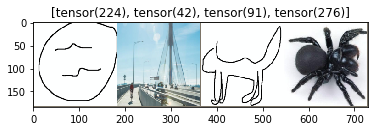

In [58]:
sample_idx, sample_img, sample_label = next(iter(trainer.source_train_dataloader))
out = torchvision.utils.make_grid(sample_img)

imshow(out, title=[x for x in sample_label])

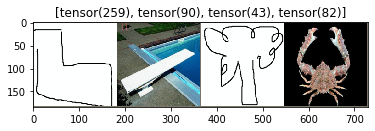

In [59]:
sample_idx, sample_img, sample_label = next(iter(trainer.source_test_dataloader))
out = torchvision.utils.make_grid(sample_img)

imshow(out, title=[x for x in sample_label])

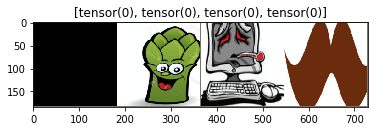

In [60]:
sample_idx, sample_img, sample_label = next(iter(trainer.target_train_dataloader))
out = torchvision.utils.make_grid(sample_img)

imshow(out, title=[x for x in sample_label])

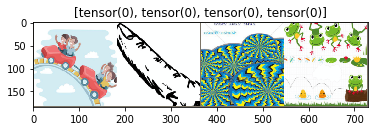

In [61]:
sample_idx, sample_img, sample_label = next(iter(trainer.target_test_dataloader))
out = torchvision.utils.make_grid(sample_img)

imshow(out, title=[x for x in sample_label])